In [1]:
!pip install rectools optuna shap catboost > None

In [2]:
import os
import datetime

import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import csr_matrix

import requests
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from rectools.metrics import MAP, calc_metrics, Recall, NDCG
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel
from rectools.models.popular import PopularModel
from rectools import Columns
from rectools.dataset import Dataset

from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization

from lightgbm import LGBMRanker
from xgboost import XGBRanker
from catboost import CatBoostRanker, Pool

import optuna

import dill

from typing import Callable, Dict, Set, List, Optional, Any, Tuple
import gc
from timeit import Timer

import shap

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
%cd gdrive/MyDrive/recsys/

/content/gdrive/MyDrive/recsys


In [6]:
os.environ["OPENBLAS_NUM_THREADS"] = "0"

In [7]:
SEED = 2022
K_RECOS = 10

## Utils

In [8]:
def avg_user_metric(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        user_ids: np.ndarray,
        metric_function: Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.
    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                group_true = y_true[l_ind: r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score

In [9]:
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'map@10': MAP(k = 10),
        'recall@10': Recall(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

## Get data

In [10]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

In [11]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


### Interactions

In [12]:
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    }, 
    inplace=True,
) 
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)
interactions.head()

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


### Users

In [14]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {} 

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)
users.head()

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0
3,721985,3,2,0,0
4,704055,2,4,0,0


### Items

In [15]:
items_cat_cols = [
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)
items.head()

,item_id,content_type,release_year,for_kids,age_rating,studios
0,10711,0,2002.0,-1,16.0,-1
1,2508,0,2014.0,-1,16.0,-1
2,10716,0,2011.0,-1,16.0,-1
3,7868,0,2015.0,-1,16.0,-1
4,16268,0,1978.0,-1,12.0,33


## Train/test split

In [16]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [17]:
ranker_train_size = 0.7
ranker_val_size = 0.15
ranker_test_size = 0.15

In [18]:
ranker_days_count = 30
ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

In [19]:
train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=SEED, test_size=ranker_test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=SEED, test_size=ranker_val_size / (ranker_train_size + ranker_val_size)
)

In [20]:
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

## Create ranker dataset

### From seminar code

In [21]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head(3)


,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


### Custom features

In [22]:
# Users age mode for current item
full_base_data = base_models_data.merge(users, on='user_id', how='left')
full_base_data['age'] = full_base_data['age'].astype(float)
age_mode_data = full_base_data.groupby('item_id')['age'].agg(lambda x: stats.mode(x)[0][0]).reset_index().rename(columns={'age': 'user_age_mode'})
full_base_data = full_base_data.merge(age_mode_data, on='item_id', how='left')

# Users income mode for current item
full_base_data['income'] = full_base_data['income'].astype(float)
income_mode_data = full_base_data.groupby('item_id')['income'].agg(lambda x: stats.mode(x)[0][0]).reset_index().rename(columns={'income': 'user_income_mode'})
full_base_data = full_base_data.merge(income_mode_data, on='item_id', how='left')

# Item's popularity with kids
full_base_data['kids_flg_float'] = full_base_data['kids_flg'].astype(float)
full_base_data['kids_flg_float'] = full_base_data['kids_flg_float'].fillna(-1)
kids_pop_data = full_base_data[
    full_base_data['kids_flg_float'] != -1
].groupby('item_id')['kids_flg_float'].sum() / full_base_data[full_base_data['kids_flg_float'] != -1].groupby('item_id')['kids_flg_float'].count()
full_base_data = full_base_data.merge(kids_pop_data.reset_index().rename(columns={'kids_flg_float': 'kids_pop'}), on='item_id', how='left')

# Item's popularity with female/male
full_base_data['sex_float'] = full_base_data['sex'].astype(float)
full_base_data['sex_float'] = full_base_data['sex_float'].fillna(-1)
male_pop_data = full_base_data[
    full_base_data['sex_float'] != -1
].groupby('item_id')['sex_float'].sum() / full_base_data[full_base_data['sex_float'] != -1].groupby('item_id')['sex_float'].count()
full_base_data = full_base_data.merge(male_pop_data.reset_index().rename(columns={'sex_float': 'male_pop'}), on='item_id', how='left')

full_base_data['female_pop'] = 1 - full_base_data['male_pop']

full_base_data = full_base_data.drop(['kids_flg_float', 'sex_float', 'datetime'], axis=1)

In [23]:
assert full_base_data.shape[0] == base_models_data.shape[0]

In [24]:
del age_mode_data, income_mode_data, kids_pop_data, male_pop_data, interactions #base_models_data
gc.collect()

31

### Items/users features joining

In [25]:
for col in full_base_data.columns:
  if isinstance(full_base_data[col].dtype, pd.CategoricalDtype):
    if -1 not in full_base_data[col].cat.categories:
      full_base_data[col] = full_base_data[col].cat.add_categories(-1)
      full_base_data.fillna({col: -1}, inplace=True)
  else:
     full_base_data.fillna({col: -1}, inplace=True)

In [26]:
items = pd.merge(
    left=items, 
    right=(
        full_base_data
        [['item_id', 'item_pop', 'item_avg_hist', 'user_age_mode', 'user_income_mode', 'kids_pop', 'male_pop', 'female_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users.drop(['age', 'income', 'kids_flg', 'sex'], axis=1), 
    right=(
        full_base_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop', 'age', 'income', 'kids_flg', 'sex']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,user_hist,user_avg_pop,user_last_pop,age,income,kids_flg,sex
0,973171,5.0,19550.800000,93403.0,1.0,4.0,1,1
1,962099,13.0,1329.307692,260.0,0.0,2.0,0,1
2,1047345,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
items.head(3)

,item_id,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,user_age_mode,user_income_mode,kids_pop,male_pop,female_pop
0,10711,0,2002.0,-1,16.0,-1,4.0,63.250000,0.0,2.0,0.0,0.333333,0.666667
1,2508,0,2014.0,-1,16.0,-1,9.0,75.222222,-1.0,2.0,0.2,0.600000,0.400000
2,10716,0,2011.0,-1,16.0,-1,6.0,65.666667,0.0,3.0,0.4,0.400000,0.600000


#### Default features

In [28]:
for col in ['item_pop', 'item_avg_hist', 'male_pop', 'female_pop']:
  default_values_items[col] = full_base_data[col].median()

for col in ['content_type',  'kids_pop']:
  default_values_items[col] = 0

for col in ['for_kids', 'studios', 'user_income_mode', 'user_age_mode']:
  default_values_items[col] = -1
  
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': full_base_data['user_avg_pop'].median(),
    'user_last_pop': full_base_data['user_last_pop'].median(),
}

### Build ranker dataset

In [29]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
    how='right'
) -> pd.DataFrame:
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how=how,  # ? 
        on=['user_id', 'item_id']
    )
    
    default_values = {
        'als_score': df['als_score'].min() - 0.01,
        'als_rank': df['als_rank'].max() + 1,
        'lfm_score': df['lfm_score'].min() - 0.01,
        'lfm_rank': df['lfm_rank'].max() + 1,
        'pop_score': df['pop_score'].min() - 0.01,
        'pop_rank': df['pop_rank'].max() + 1,
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

In [30]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

In [31]:
candidates_df = pd.read_csv('als_candidates.csv').rename(
    columns={'rank': 'als_rank', 'score': 'als_score'}
).merge(
    pd.read_csv('lfm_candidates.csv').rename(
      columns={'rank': 'lfm_rank', 'score': 'lfm_score'}
    ),
    on=['user_id', 'item_id'],
     how='outer'
)
candidates_df = candidates_df[candidates_df['lfm_rank'] < 31]

top_popular = pd.read_csv('popular_candidates.csv').rename(columns={'rank': 'pop_rank', 'score': 'pop_score'}).drop('user_id', axis=1)
candidates_df = candidates_df.merge(top_popular, on='item_id', how='left')

candidates_df.head()

,user_id,item_id,als_score,als_rank,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,13865,0.413584,1.0,1.994332,1.0,93403.0,3
1,176549,10440,0.405836,2.0,1.535397,4.0,141889.0,1
2,176549,7571,0.266977,4.0,1.838475,3.0,20407.0,16
3,176549,4151,0.250057,5.0,1.295747,18.0,69641.0,5
4,176549,3734,0.232546,6.0,1.530712,5.0,50004.0,7


In [32]:
ranker_train = users_filter(train_users, candidates_df, ranker_data)
ranker_val = users_filter(val_users, candidates_df, ranker_data)
ranker_test = users_filter(test_users, candidates_df, ranker_data)

ranker_train.head()

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,lfm_score,lfm_rank,pop_score,pop_rank
1683902,3,142,2021-08-13,5892.0,100.0,0.130356,6.0,3.313618,7.0,35862.0,9
3835442,3,849,2021-07-01,0.0,0.0,-0.006549,31.0,2.616008,27.0,13304.0,27
3835441,3,1819,2021-07-01,0.0,0.0,-0.006549,31.0,2.678070,25.0,9792.0,34
1683909,3,1844,2021-07-01,0.0,0.0,0.047299,13.0,2.977912,15.0,22344.0,15
3835438,3,2657,2021-07-01,0.0,0.0,-0.006549,31.0,3.282620,9.0,55146.0,6


In [33]:
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,lfm_score,lfm_rank,pop_score,...,for_kids,age_rating,studios,item_pop,item_avg_hist,user_age_mode,user_income_mode,kids_pop,male_pop,female_pop
0,3,142,2021-08-13,5892.0,100.0,0.130356,6.0,3.313618,7.0,35862.0,...,-1,16.0,-1,35862.0,15.251464,2.0,2.0,0.366487,0.470470,0.529530
1,3,849,2021-07-01,0.0,0.0,-0.006549,31.0,2.616008,27.0,13304.0,...,-1,18.0,-1,13304.0,16.444678,2.0,2.0,0.349387,0.655714,0.344286
2,3,1819,2021-07-01,0.0,0.0,-0.006549,31.0,2.678070,25.0,9792.0,...,-1,16.0,-1,9792.0,14.719669,1.0,2.0,0.349565,0.594162,0.405838


## Fit rankers

In [34]:
del candidates_df, full_base_data #, users, items
gc.collect()

0

In [35]:
def print_study_info(study):
  print("Number of finished trials: ", len(study.trials))
  print("Best trial:")
  trials = study.best_trials
  for trial in trials:
    print("  Params: ")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

In [36]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

In [37]:
def add_simple_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

In [38]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    df[f'{name}_score'] = y_pred_scores
    df = df.drop_duplicates(['user_id', 'item_id'], keep='last')
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    mask = ((df['lfm_rank'] < 31) & (df['als_rank'] < 31) & df['pop_rank'] < 31).to_numpy()

    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )

    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 31
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [39]:
ranker_train = add_simple_target(ranker_train)
ranker_val = add_simple_target(ranker_val)
ranker_test = add_simple_target(ranker_test)

In [40]:
ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,lfm_score,lfm_rank,pop_score,...,studios,item_pop,item_avg_hist,user_age_mode,user_income_mode,kids_pop,male_pop,female_pop,target,target_ranker
0,3,142,2021-08-13,5892.0,100.0,0.130356,6.0,3.313618,7.0,35862.0,...,-1,35862.0,15.251464,2.0,2.0,0.366487,0.470470,0.529530,1,2
1,3,849,2021-07-01,0.0,0.0,-0.006549,31.0,2.616008,27.0,13304.0,...,-1,13304.0,16.444678,2.0,2.0,0.349387,0.655714,0.344286,0,0
2,3,1819,2021-07-01,0.0,0.0,-0.006549,31.0,2.678070,25.0,9792.0,...,-1,9792.0,14.719669,1.0,2.0,0.349565,0.594162,0.405838,0,0


In [41]:
cols = [
    'als_score', 'als_rank', 'lfm_score', 'lfm_rank', 'pop_score', 'pop_rank', 'user_hist', 'user_avg_pop', 'user_last_pop', 'age', 'income', 'kids_flg', 'sex',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist', 'user_age_mode', 'user_income_mode', 'kids_pop', 'male_pop', 'female_pop'
]

cat_cols = ['age', 'income', 'sex', 'kids_flg', 'content_type', 'for_kids', 'studios', 'user_age_mode', 'user_income_mode']

In [42]:
for col in ['kids_flg', 'sex', 'content_type', 'for_kids', 'studios']:
  ranker_train[col] = ranker_train[col].astype(int)
  ranker_val[col] = ranker_val[col].astype(int)
  ranker_test[col] = ranker_test[col].astype(int)

### LGBMRanker

In [43]:
# https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMRanker.html?highlight=ranker

def get_lgbm_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']].groupby(by=['user_id']).count()['item_id']
    )

#### Optimize hyperparams

In [47]:
def objective_LGBM_Ranker(trial):
    n_estimators = trial.suggest_int("n_estimators", low=2000, high=10000, step=200)
    max_depth = trial.suggest_int("max_depth", low=3, high=5, step=1)
    num_leaves = trial.suggest_int("num_leaves", low=(2**max_depth) - 2*max_depth, high=(2**max_depth) - max_depth, step=1)
    learning_rate = trial.suggest_float("learning_rate", low=0.1, high=0.3, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", low=0.7, high=0.9, step=0.1)
    min_child_samples = trial.suggest_int("min_child_samples", low=50, high=100, step=10)

    early_stopping_rounds = 32

    params = {
        'objective': 'lambdarank', 
        'n_estimators': n_estimators,  
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'min_child_samples': min_child_samples, 
        'learning_rate': learning_rate, 
        'reg_lambda': 1, 
        'colsample_bytree': colsample_bytree,
        'random_state': 42,
    }

    fit_params = {
        'X': ranker_train[cols],
        'y': ranker_train['target_ranker'],
        'group': get_lgbm_group(ranker_train),
        'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
        'eval_group': [get_lgbm_group(ranker_val)],
        'eval_metric': 'ndcg',
        'eval_at': (3, 5, 10),
        'early_stopping_rounds': early_stopping_rounds,
        'categorical_feature': cat_cols,
        'feature_name': cols,
        'verbose': early_stopping_rounds / 4,
    }
    listwise_model = LGBMRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')
    return metric_values['map@10'], metric_values['recall@10']

In [48]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective_LGBM_Ranker, n_trials=10)

[I 2022-12-11 11:11:12,148] A new study created in memory with name: no-name-0911b0b0-b152-411b-ac1d-b63bb8981e09


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[282]	valid_0's ndcg@3: 0.787179	valid_0's ndcg@5: 0.808766	valid_0's ndcg@10: 0.828304	valid_0's ndcg@3: 0.787179	valid_0's ndcg@5: 0.808766	valid_0's ndcg@10: 0.828304


[I 2022-12-11 11:15:34,064] Trial 0 finished with values: [0.04896425583715544, 0.0869878841774328] and parameters: {'n_estimators': 9000, 'max_depth': 5, 'num_leaves': 25, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 70}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[650]	valid_0's ndcg@3: 0.780923	valid_0's ndcg@5: 0.801863	valid_0's ndcg@10: 0.818918	valid_0's ndcg@3: 0.780923	valid_0's ndcg@5: 0.801863	valid_0's ndcg@10: 0.818918


[I 2022-12-11 11:21:27,802] Trial 1 finished with values: [0.0467446053857142, 0.08472301594350921] and parameters: {'n_estimators': 6200, 'max_depth': 3, 'num_leaves': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 60}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[186]	valid_0's ndcg@3: 0.787281	valid_0's ndcg@5: 0.808481	valid_0's ndcg@10: 0.828117	valid_0's ndcg@3: 0.787281	valid_0's ndcg@5: 0.808481	valid_0's ndcg@10: 0.828117


[I 2022-12-11 11:23:56,219] Trial 2 finished with values: [0.048769831667075755, 0.08687444912906307] and parameters: {'n_estimators': 3200, 'max_depth': 4, 'num_leaves': 10, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 70}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[605]	valid_0's ndcg@3: 0.784887	valid_0's ndcg@5: 0.806611	valid_0's ndcg@10: 0.825488	valid_0's ndcg@3: 0.784887	valid_0's ndcg@5: 0.806611	valid_0's ndcg@10: 0.825488


[I 2022-12-11 11:29:48,961] Trial 3 finished with values: [0.04791942143604169, 0.0858470831433127] and parameters: {'n_estimators': 5800, 'max_depth': 3, 'num_leaves': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'min_child_samples': 70}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[127]	valid_0's ndcg@3: 0.78169	valid_0's ndcg@5: 0.802715	valid_0's ndcg@10: 0.820707	valid_0's ndcg@3: 0.78169	valid_0's ndcg@5: 0.802715	valid_0's ndcg@10: 0.820707


[I 2022-12-11 11:31:19,013] Trial 4 finished with values: [0.04698661988580662, 0.08481136181639244] and parameters: {'n_estimators': 7000, 'max_depth': 3, 'num_leaves': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'min_child_samples': 100}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[507]	valid_0's ndcg@3: 0.785371	valid_0's ndcg@5: 0.807044	valid_0's ndcg@10: 0.825902	valid_0's ndcg@3: 0.785371	valid_0's ndcg@5: 0.807044	valid_0's ndcg@10: 0.825902


[I 2022-12-11 11:36:58,052] Trial 5 finished with values: [0.04808563974636456, 0.08590401230568764] and parameters: {'n_estimators': 6400, 'max_depth': 3, 'num_leaves': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 50}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[246]	valid_0's ndcg@3: 0.787144	valid_0's ndcg@5: 0.80834	valid_0's ndcg@10: 0.828106	valid_0's ndcg@3: 0.787144	valid_0's ndcg@5: 0.80834	valid_0's ndcg@10: 0.828106


[I 2022-12-11 11:40:51,109] Trial 6 finished with values: [0.0488547220937088, 0.08682481814833386] and parameters: {'n_estimators': 4200, 'max_depth': 5, 'num_leaves': 27, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 60}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[420]	valid_0's ndcg@3: 0.786547	valid_0's ndcg@5: 0.807789	valid_0's ndcg@10: 0.827494	valid_0's ndcg@3: 0.786547	valid_0's ndcg@5: 0.807789	valid_0's ndcg@10: 0.827494


[I 2022-12-11 11:45:57,461] Trial 7 finished with values: [0.04844295703856582, 0.08648674059307211] and parameters: {'n_estimators': 7200, 'max_depth': 4, 'num_leaves': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 60}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[129]	valid_0's ndcg@3: 0.786461	valid_0's ndcg@5: 0.808177	valid_0's ndcg@10: 0.82751	valid_0's ndcg@3: 0.786461	valid_0's ndcg@5: 0.808177	valid_0's ndcg@10: 0.82751


[I 2022-12-11 11:47:50,763] Trial 8 finished with values: [0.048560789424927774, 0.08657634785710615] and parameters: {'n_estimators': 4400, 'max_depth': 4, 'num_leaves': 10, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 80}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[145]	valid_0's ndcg@3: 0.787555	valid_0's ndcg@5: 0.808873	valid_0's ndcg@10: 0.828242	valid_0's ndcg@3: 0.787555	valid_0's ndcg@5: 0.808873	valid_0's ndcg@10: 0.828242


[I 2022-12-11 11:49:57,886] Trial 9 finished with values: [0.048881665274169026, 0.08714472826067146] and parameters: {'n_estimators': 8400, 'max_depth': 5, 'num_leaves': 22, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'min_child_samples': 60}. 


CPU times: user 38min 37s, sys: 8.34 s, total: 38min 45s
Wall time: 38min 45s


In [49]:
print_study_info(study)

Number of finished trials:  10
Best trial:
  Params: 
    n_estimators: 9000
    max_depth: 5
    num_leaves: 25
    learning_rate: 0.1
    colsample_bytree: 0.8999999999999999
    min_child_samples: 70
  Params: 
    n_estimators: 8400
    max_depth: 5
    num_leaves: 22
    learning_rate: 0.2
    colsample_bytree: 0.7
    min_child_samples: 60


In [56]:
del study
gc.collect()

21925

#### Refit best model

In [50]:
params = {
    'objective': 'lambdarank', 
    'n_estimators': 9000, 
    'max_depth': 5, 
    'num_leaves': 25, 
    'min_child_samples': 70,
    'learning_rate': 0.1, 
    'reg_lambda': 1, 
    'colsample_bytree': 0.9, 
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_lgbm_group(ranker_train),
    'eval_set': [(ranker_test[cols], ranker_val['target_ranker'])],
    'eval_group': [get_lgbm_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[289]	valid_0's ndcg@3: 0.787411	valid_0's ndcg@5: 0.809214	valid_0's ndcg@10: 0.82874	valid_0's ndcg@3: 0.787411	valid_0's ndcg@5: 0.809214	valid_0's ndcg@10: 0.82874


LGBMRanker(colsample_bytree=0.9, max_depth=5, min_child_samples=70,
           n_estimators=9000, num_leaves=25, objective='lambdarank',
           random_state=42, reg_lambda=1)

In [51]:
listwise_model.best_score_['valid_0']

{'ndcg@3': 0.7874113550981784,
 'ndcg@5': 0.8092136619033398,
 'ndcg@10': 0.8287401575203904}

In [52]:
with open(f'lgbm_ranker_model.dill', 'wb') as f:
    dill.dump(listwise_model, f)

In [71]:
with open(f'lgbm_ranker_model.dill', 'rb') as f:
    listwise_model = dill.load(f)

In [72]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,lfm_score,lfm_rank,pop_score,...,user_income_mode,kids_pop,male_pop,female_pop,target,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
17,21,9728,2021-07-01,0.0,0.0,0.466275,3.0,2.978701,2.0,76978.0,...,2.0,0.354635,0.569101,0.430899,0,0,0.834300,1,0.834300,1
28,21,15297,2021-07-01,0.0,0.0,0.972348,1.0,2.444666,5.0,137128.0,...,2.0,0.344070,0.317637,0.682363,0,0,0.732737,2,0.732737,2
7,21,3734,2021-07-01,0.0,0.0,0.449836,4.0,2.482403,4.0,50004.0,...,2.0,0.365684,0.473830,0.526170,0,0,0.481855,3,0.481855,3


In [73]:
models_metrics = {}
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise_hybrid']]

,listwise_hybrid
map@10,0.048989
recall@10,0.086998


#### Interpretation

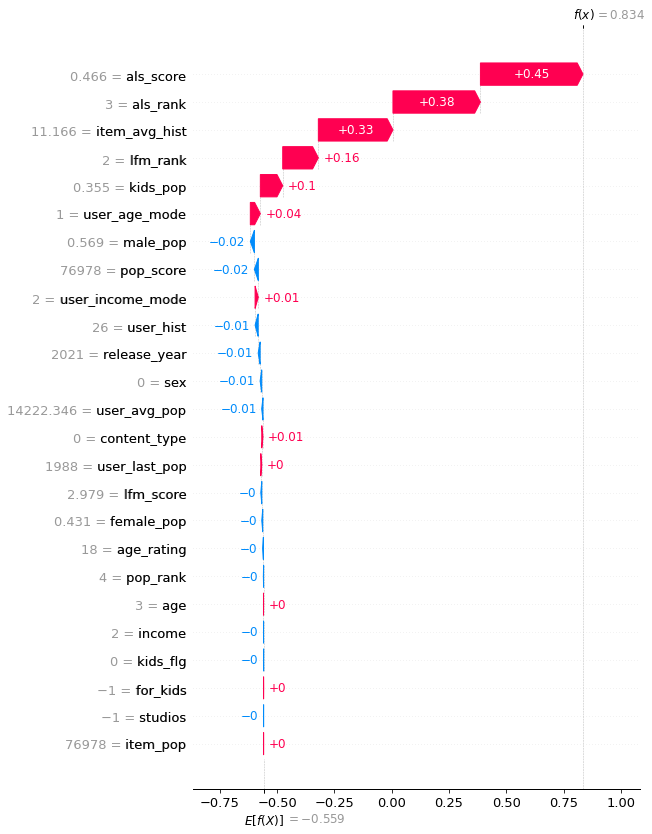

In [55]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

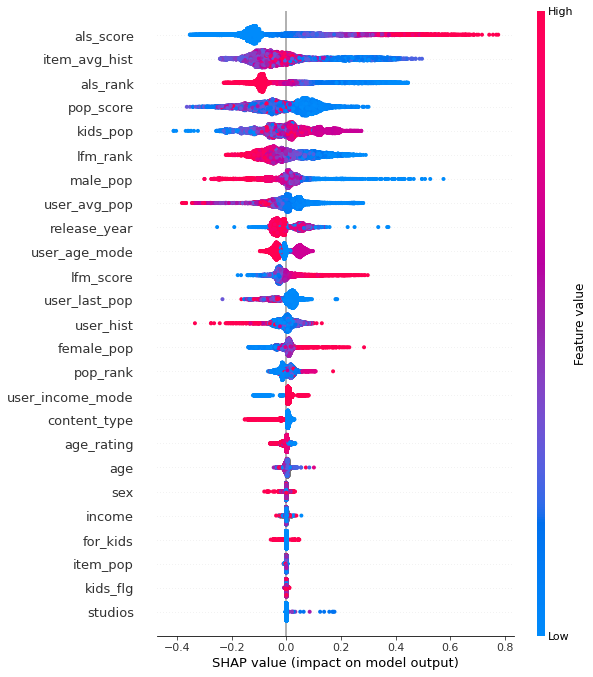

In [57]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [58]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']), 
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.8287792220205714, 0.8287792220205714)

### XGBRanker

In [59]:
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRanker

def get_xgb_group(df):
    return np.array(
        df[['user_id', 'item_id']].groupby(by=['user_id']).count()['item_id']
    )

#### Optimize hyperparams

In [60]:
def objective_XGBoost_Ranker(trial):
    n_estimators = trial.suggest_int("n_estimators", low=100, high=200, step=50)
    max_depth = trial.suggest_int("max_depth", low=3, high=5, step=1)
    learning_rate = trial.suggest_float("learning_rate", low=0.1, high=0.3, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", low=0.7, high=0.9, step=0.1)

    early_stopping_rounds = 32

    params = {
        'objective': 'rank:ndcg', 
        'n_estimators': n_estimators,  
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'reg_lambda': 1,
        'colsample_bytree': colsample_bytree,
        'random_state': 42,
        'early_stopping_rounds': early_stopping_rounds,
        'eval_metric': 'ndcg@10',
    }

    fit_params = {
        'X': ranker_train[cols],
        'y': ranker_train['target_ranker'],
        'group': get_xgb_group(ranker_train),
        'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
        'eval_group': [get_xgb_group(ranker_val)],
        'early_stopping_rounds': early_stopping_rounds,
        'verbose': early_stopping_rounds / 2,
    }
    listwise_model = XGBRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')
    return metric_values['map@10'], metric_values['recall@10']

In [61]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective_XGBoost_Ranker, n_trials=5)

[I 2022-12-11 12:03:49,284] A new study created in memory with name: no-name-422295a4-6d6f-405d-a322-67f2ff74eb76


Will train until eval_0-ndcg@10 hasn't improved in 32 rounds.


[I 2022-12-11 12:15:15,097] Trial 0 finished with values: [0.04874089905593669, 0.08677799862996076] and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.7}. 


Will train until eval_0-ndcg@10 hasn't improved in 32 rounds.


[I 2022-12-11 12:27:38,637] Trial 1 finished with values: [0.04724650989081636, 0.0849732072749882] and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999}. 


Will train until eval_0-ndcg@10 hasn't improved in 32 rounds.


[I 2022-12-11 12:38:38,886] Trial 2 finished with values: [0.04815075416148499, 0.08641848204610522] and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.7999999999999999}. 


Will train until eval_0-ndcg@10 hasn't improved in 32 rounds.


[I 2022-12-11 12:50:37,642] Trial 3 finished with values: [0.04827732004139828, 0.08619008186693232] and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}. 


Will train until eval_0-ndcg@10 hasn't improved in 32 rounds.


[I 2022-12-11 12:58:01,181] Trial 4 finished with values: [0.04750117082272419, 0.08537346403834635] and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7999999999999999}. 


CPU times: user 54min 5s, sys: 12.2 s, total: 54min 17s
Wall time: 54min 11s


In [62]:
print_study_info(study)

Number of finished trials:  5
Best trial:
  Params: 
    n_estimators: 100
    max_depth: 5
    learning_rate: 0.3
    colsample_bytree: 0.7


In [63]:
del study
gc.collect()

10480

#### Refit best model

In [64]:
params = {
  'objective': 'rank:ndcg', 
  'n_estimators': 100,  
  'max_depth': 5,
  'learning_rate': 0.3,
  'reg_lambda': 1,
  'colsample_bytree': 0.7,
  'random_state': 42,
  'early_stopping_rounds': 32,
  'eval_metric': 'ndcg@10',
}

fit_params = {
  'X': ranker_train[cols],
  'y': ranker_train['target_ranker'],
  'group': get_xgb_group(ranker_train),
  'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
  'eval_group': [get_xgb_group(ranker_val)],
  'early_stopping_rounds': 32,
  'verbose': 32 / 8,
}
listwise_model = XGBRanker(**params)
listwise_model.fit(**fit_params)

y_pred = listwise_model.predict(ranker_test[cols])
metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')

Will train until eval_0-ndcg@10 hasn't improved in 32 rounds.


In [65]:
with open(f'xgb_ranker_model.dill', 'wb') as f:
    dill.dump(listwise_model, f)

In [66]:
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')

In [67]:
models_metrics = {}
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise_hybrid']]

,listwise_hybrid
map@10,0.048741
recall@10,0.086778


#### Interpretation

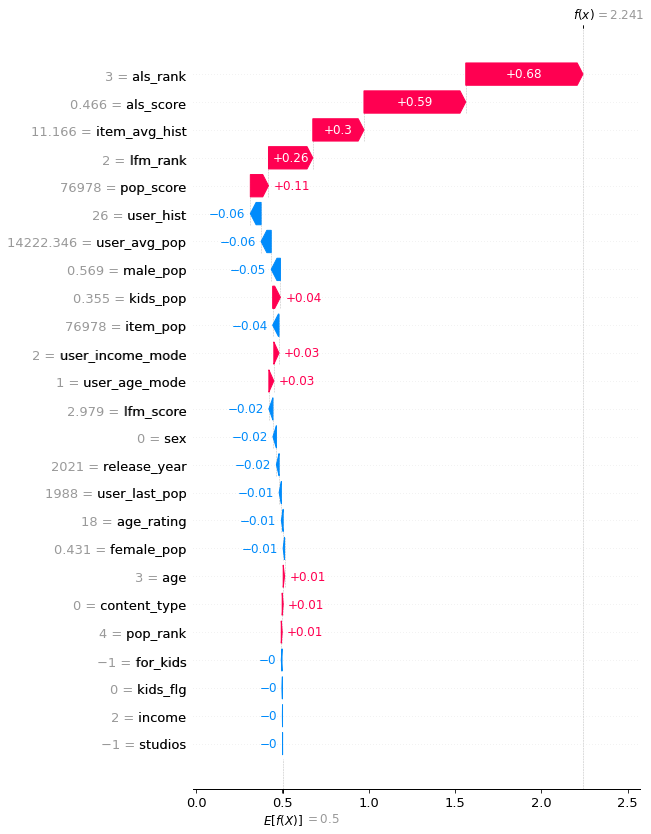

In [68]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

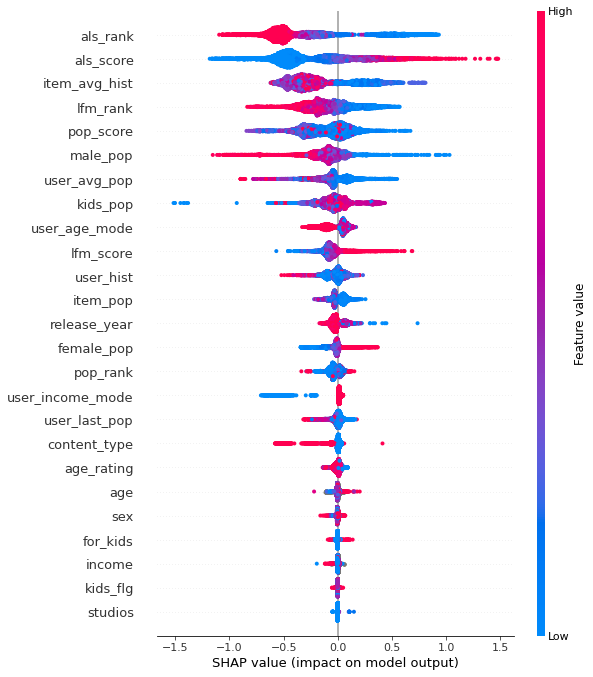

In [69]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [70]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.8273020880189578, 0.8273020880189578)

### CatBoostRanker

#### Optimize hyperparams

In [43]:
def objective_CatBoost_Ranker(trial):
    iterations = trial.suggest_int("iterations", low=100, high=200, step=50)
    depth = trial.suggest_int("depth", low=3, high=5, step=1)
    learning_rate = trial.suggest_float("learning_rate", low=0.1, high=0.3, step=0.1)
    reg_lambda = trial.suggest_float("reg_lambda", low=0.1, high=1, step=0.1)

    early_stopping_rounds = 32

    train_pool = Pool(
        data=ranker_train[cols],
        label=ranker_train['target_ranker'],
        group_id=ranker_train['user_id'].values
    )
    test_pool = Pool(
        data=ranker_val[cols],
        label=ranker_val['target_ranker'],
        group_id=ranker_val['user_id'].values
    )

    params = {
        'iterations': iterations,
        'depth': depth,
        'learning_rate': learning_rate,
        'reg_lambda': reg_lambda, 
        'random_seed': 42,
        'early_stopping_rounds': 32,
        'custom_metric': ['NDCG:top=10'],
        'verbose': 1,
    }

    fit_params = {
        'X': train_pool,
        #'y': ranker_train['target_ranker'],
        'eval_set': test_pool,
        'early_stopping_rounds': early_stopping_rounds,
        'plot': 1,
        'verbose': 16,
    }
    listwise_model = CatBoostRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')
    return metric_values['map@10'], metric_values['recall@10']

In [44]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective_CatBoost_Ranker, n_trials=5)

[I 2022-12-11 13:22:31,833] A new study created in memory with name: no-name-90e7b623-d261-408e-a8d0-e7681d5ebfe7


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7909782	best: 0.7909782 (0)	total: 3.41s	remaining: 5m 38s
16:	test: 0.8447005	best: 0.8447005 (16)	total: 55.1s	remaining: 4m 29s
32:	test: 0.8463187	best: 0.8463528 (31)	total: 1m 48s	remaining: 3m 40s
48:	test: 0.8470815	best: 0.8470815 (48)	total: 2m 40s	remaining: 2m 46s
64:	test: 0.8476444	best: 0.8476444 (64)	total: 3m 32s	remaining: 1m 54s
80:	test: 0.8482312	best: 0.8482844 (79)	total: 4m 24s	remaining: 1m 1s
96:	test: 0.8486179	best: 0.8486179 (96)	total: 5m 15s	remaining: 9.76s
99:	test: 0.8486949	best: 0.8486949 (99)	total: 5m 26s	remaining: 0us

bestTest = 0.8486949173
bestIteration = 99



[I 2022-12-11 13:28:02,849] Trial 0 finished with values: [0.04779789221253596, 0.08643910722091912] and parameters: {'iterations': 100, 'depth': 4, 'learning_rate': 0.3, 'reg_lambda': 0.30000000000000004}. 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7947767	best: 0.7947767 (0)	total: 3.36s	remaining: 5m 33s
16:	test: 0.8448998	best: 0.8448998 (16)	total: 58s	remaining: 4m 43s
32:	test: 0.8468245	best: 0.8468245 (32)	total: 1m 51s	remaining: 3m 45s
48:	test: 0.8475092	best: 0.8475092 (48)	total: 2m 47s	remaining: 2m 54s
64:	test: 0.8477665	best: 0.8477931 (62)	total: 3m 40s	remaining: 1m 58s
80:	test: 0.8482870	best: 0.8482870 (80)	total: 4m 35s	remaining: 1m 4s
96:	test: 0.8484405	best: 0.8484415 (95)	total: 5m 28s	remaining: 10.2s
99:	test: 0.8485757	best: 0.8485757 (99)	total: 5m 38s	remaining: 0us

bestTest = 0.8485756879
bestIteration = 99



[I 2022-12-11 13:33:46,611] Trial 1 finished with values: [0.04787847351631479, 0.08663394203922103] and parameters: {'iterations': 100, 'depth': 5, 'learning_rate': 0.2, 'reg_lambda': 0.7000000000000001}. 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7797376	best: 0.7797376 (0)	total: 3.28s	remaining: 5m 25s
16:	test: 0.8429644	best: 0.8429644 (16)	total: 53.8s	remaining: 4m 22s
32:	test: 0.8453325	best: 0.8453325 (32)	total: 1m 44s	remaining: 3m 32s
48:	test: 0.8460599	best: 0.8460599 (48)	total: 2m 36s	remaining: 2m 42s
64:	test: 0.8469220	best: 0.8469220 (64)	total: 3m 27s	remaining: 1m 51s
80:	test: 0.8469159	best: 0.8470213 (70)	total: 4m 17s	remaining: 1m
96:	test: 0.8472377	best: 0.8473531 (88)	total: 5m 8s	remaining: 9.54s
99:	test: 0.8473332	best: 0.8473531 (88)	total: 5m 18s	remaining: 0us

bestTest = 0.8473530724
bestIteration = 88

Shrink model to first 89 iterations.


[I 2022-12-11 13:39:08,963] Trial 2 finished with values: [0.04726971315978066, 0.08587336807470713] and parameters: {'iterations': 100, 'depth': 3, 'learning_rate': 0.3, 'reg_lambda': 0.6}. 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7909825	best: 0.7909825 (0)	total: 3.25s	remaining: 8m 3s
16:	test: 0.8435930	best: 0.8435930 (16)	total: 57.8s	remaining: 7m 32s
32:	test: 0.8452644	best: 0.8453047 (29)	total: 1m 53s	remaining: 6m 41s
48:	test: 0.8467554	best: 0.8467554 (48)	total: 2m 45s	remaining: 5m 40s
64:	test: 0.8472678	best: 0.8472678 (64)	total: 3m 37s	remaining: 4m 44s
80:	test: 0.8477951	best: 0.8477951 (80)	total: 4m 31s	remaining: 3m 51s
96:	test: 0.8479880	best: 0.8480376 (91)	total: 5m 23s	remaining: 2m 57s
112:	test: 0.8482647	best: 0.8482647 (112)	total: 6m 16s	remaining: 2m 3s
128:	test: 0.8482720	best: 0.8482720 (128)	total: 7m 8s	remaining: 1m 9s
144:	test: 0.8483494	best: 0.8484347 (136)	total: 8m 2s	remaining: 16.6s
149:	test: 0.8483266	best: 0.8484347 (136)	total: 8m 18s	remaining: 0us

bestTest = 0.8484346776
bestIteration = 136

Shrink model to first 137 iterations.


[I 2022-12-11 13:47:33,074] Trial 3 finished with values: [0.047779266905639745, 0.08636549683659092] and parameters: {'iterations': 150, 'depth': 4, 'learning_rate': 0.2, 'reg_lambda': 0.1}. 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7797376	best: 0.7797376 (0)	total: 3.26s	remaining: 10m 49s
16:	test: 0.8411803	best: 0.8411803 (16)	total: 54.3s	remaining: 9m 44s
32:	test: 0.8441447	best: 0.8441447 (32)	total: 1m 44s	remaining: 8m 51s
48:	test: 0.8451939	best: 0.8451939 (48)	total: 2m 35s	remaining: 7m 59s
64:	test: 0.8460344	best: 0.8460346 (63)	total: 3m 30s	remaining: 7m 16s
80:	test: 0.8465520	best: 0.8465520 (80)	total: 4m 21s	remaining: 6m 24s
96:	test: 0.8467130	best: 0.8467130 (96)	total: 5m 12s	remaining: 5m 32s
112:	test: 0.8470684	best: 0.8470684 (112)	total: 6m 3s	remaining: 4m 40s
128:	test: 0.8473218	best: 0.8473218 (128)	total: 6m 56s	remaining: 3m 49s
144:	test: 0.8473285	best: 0.8473632 (142)	total: 7m 47s	remaining: 2m 57s
160:	test: 0.8476344	best: 0.8476344 (160)	total: 8m 38s	remaining: 2m 5s
176:	test: 0.8477563	best: 0.8477563 (176)	total: 9m 29s	remaining: 1m 14s
192:	test: 0.8478623	best: 0.8478802 (184)	total: 10m 20s	remaining: 22.5s
199:	test: 0.8479894	best: 0.8479894 (199)	t

[I 2022-12-11 13:58:23,050] Trial 4 finished with values: [0.047651544020772846, 0.0861566332378673] and parameters: {'iterations': 200, 'depth': 3, 'learning_rate': 0.2, 'reg_lambda': 0.4}. 


CPU times: user 1h 5min 36s, sys: 1min 40s, total: 1h 7min 16s
Wall time: 35min 51s


In [45]:
print_study_info(study)

Number of finished trials:  5
Best trial:
  Params: 
    iterations: 100
    depth: 5
    learning_rate: 0.2
    reg_lambda: 0.7000000000000001


In [46]:
del study
gc.collect()

0

#### Refit best model

In [49]:
params = {
  'iterations': 100,
  'depth': 5,
  'learning_rate': 0.2,
  'reg_lambda': 0.7, 
  'random_seed': 42,
  'early_stopping_rounds': 32,
  'custom_metric': ['NDCG:top=10'],
  'verbose': 1,
}

train_pool = Pool(
  data=ranker_train[cols],
  label=ranker_train['target_ranker'],
  group_id=ranker_train['user_id'].values
)
test_pool = Pool(
  data=ranker_val[cols],
  label=ranker_val['target_ranker'],
  group_id=ranker_val['user_id'].values
)

fit_params = {
  'X': train_pool,
  'eval_set': test_pool,
  'early_stopping_rounds': 32,
  'plot': 1,
  'verbose': 16,
}
listwise_model = CatBoostRanker(**params)
listwise_model.fit(**fit_params)

y_pred = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
metric_values = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
metric_values

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7947767	best: 0.7947767 (0)	total: 4.8s	remaining: 7m 54s
16:	test: 0.8448998	best: 0.8448998 (16)	total: 59.6s	remaining: 4m 50s
32:	test: 0.8468245	best: 0.8468245 (32)	total: 1m 56s	remaining: 3m 56s
48:	test: 0.8475092	best: 0.8475092 (48)	total: 2m 49s	remaining: 2m 56s
64:	test: 0.8477665	best: 0.8477931 (62)	total: 3m 44s	remaining: 2m 1s
80:	test: 0.8482870	best: 0.8482870 (80)	total: 4m 38s	remaining: 1m 5s
96:	test: 0.8484405	best: 0.8484415 (95)	total: 5m 30s	remaining: 10.2s
99:	test: 0.8485757	best: 0.8485757 (99)	total: 5m 40s	remaining: 0us

bestTest = 0.8485756879
bestIteration = 99



{'recall@10': 0.08663394203922103, 'map@10': 0.04787847351631479}

In [50]:
with open(f'catboost_ranker_model.dill', 'wb') as f:
    dill.dump(listwise_model, f)

In [54]:
models_metrics = {}
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise_hybrid']]

,listwise_hybrid
map@10,0.047878
recall@10,0.086634


#### Interpretation

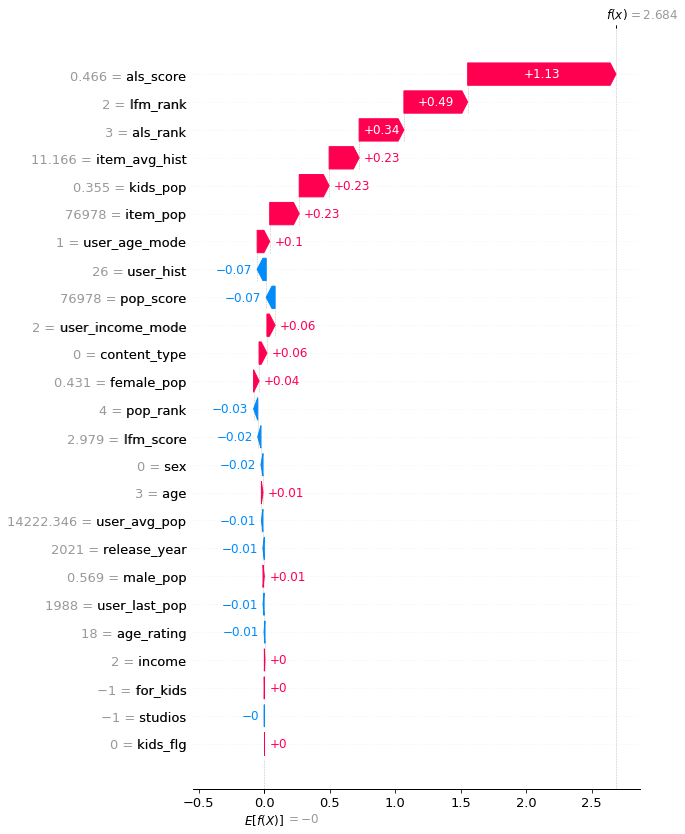

In [51]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

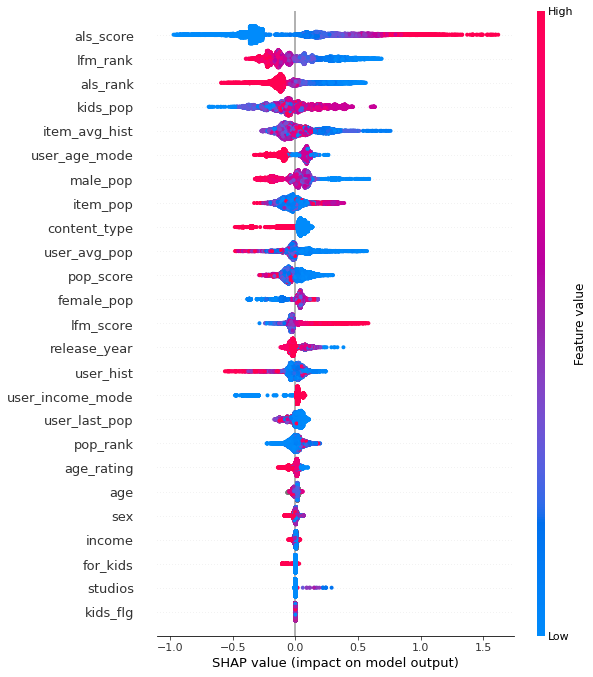

In [52]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [53]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']), 
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.8282361228017886, 0.8282361228017886)

### Rankers comparison

In [61]:
del listwise_model
gc.collect()

767

In [62]:
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'map@10': MAP(k = 10),
        'ndcg@10': NDCG(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

In [73]:
def get_metrics(model_file, train_time):
  global ranker_test
  
  with open(model_file, 'rb') as f:
    listwise_model = dill.load(f)

  y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
  ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')

  metrics = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
  metrics['train_time_sec'] = train_time

  testcode = 'listwise_model.predict(ranker_test[cols])'
  t = Timer(lambda: listwise_model.predict(ranker_test[cols]))
  metrics['prediction_time_sec'] = t.timeit(number=5) / 5

  return metrics

train_time was obtained from optuna logs and converted to seconds

In [74]:
results = {}
results['lgbm'] = get_metrics('lgbm_ranker_model.dill', train_time=263)
results['xgb'] = get_metrics('xgb_ranker_model.dill', train_time=686)
results['catboost'] = get_metrics('catboost_ranker_model.dill', train_time=474)
pd.DataFrame(results)

,lgbm,xgb,catboost
ndcg@10,0.035137,0.035049,0.034768
map@10,0.048989,0.048741,0.047878
train_time_sec,263.000000,686.000000,474.000000
prediction_time_sec,11.864178,3.375402,0.233426


The best model is LGBM ranker

## Refit best ranker on the ranker_train + ranker_val


In [44]:
ranker_train = pd.concat([ranker_train, ranker_val])
del ranker_val, ranker_data
gc.collect()

0

In [45]:
params = {
    'objective': 'lambdarank', 
    'n_estimators': 9000, 
    'max_depth': 5, 
    'num_leaves': 25, 
    'min_child_samples': 70,
    'learning_rate': 0.1, 
    'reg_lambda': 1, 
    'colsample_bytree': 0.9, 
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_lgbm_group(ranker_train),
    'eval_set': [(ranker_test[cols], ranker_test['target_ranker'])],
    'eval_group': [get_lgbm_group(ranker_test)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[169]	valid_0's ndcg@3: 0.786508	valid_0's ndcg@5: 0.808405	valid_0's ndcg@10: 0.827661	valid_0's ndcg@3: 0.786508	valid_0's ndcg@5: 0.808405	valid_0's ndcg@10: 0.827661


LGBMRanker(colsample_bytree=0.9, max_depth=5, min_child_samples=70,
           n_estimators=9000, num_leaves=25, objective='lambdarank',
           random_state=42, reg_lambda=1)

In [46]:
listwise_model.best_score_['valid_0']

{'ndcg@3': 0.7865075544531243,
 'ndcg@5': 0.8084049499955551,
 'ndcg@10': 0.8276606892553562}

In [47]:
with open(f'lgbm_ranker_model_full.dill', 'wb') as f:
    dill.dump(listwise_model, f)